In [15]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from netcal.metrics import ECE, ACE

from utils_notebook import *

from collections import OrderedDict, Counter
import random
from typing import Dict, List

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

## 0 Import logits

In [2]:
MODEL_FOLDER = 'models_use_valid'
LIKELIHOOD = 'softmax'
EPOCH = 299

In [3]:
logits_val, targets_val, ARGS = get_logits_targets('cifar100', MODEL_FOLDER, LIKELIHOOD, EPOCH, cuda=False, logits_type='val')
logits_test, targets_test, ARGS = get_logits_targets('cifar100', MODEL_FOLDER, LIKELIHOOD, EPOCH, cuda=False, logits_type='test')
logits_train, targets_train, ARGS = get_logits_targets('cifar100', MODEL_FOLDER, LIKELIHOOD, EPOCH, cuda=False, logits_type='train')

building network of steps: 
[4, 2, 2, 2, 2, 2, 2] 16
 ********************** Block 1  **********************
|		inScales 3 outScales 3 inChannels 16 outChannels 6		|

|		inScales 3 outScales 3 inChannels 22 outChannels 6		|

|		inScales 3 outScales 3 inChannels 28 outChannels 6		|

|		inScales 3 outScales 3 inChannels 34 outChannels 6		|

 ********************** Block 2  **********************
|		inScales 3 outScales 3 inChannels 40 outChannels 6		|

|		inScales 3 outScales 3 inChannels 46 outChannels 6		|

 ********************** Block 3  **********************
|		inScales 3 outScales 2 inChannels 52 outChannels 6		|
|		Transition layer inserted! (max), inChannels 58, outChannels 29	|

|		inScales 2 outScales 2 inChannels 29 outChannels 6		|

 ********************** Block 4  **********************
|		inScales 2 outScales 2 inChannels 35 outChannels 6		|

|		inScales 2 outScales 2 inChannels 41 outChannels 6		|

 ********************** Block 5  **********************
|		inScales 2 outS

/home/metod/miniconda3/envs/msdnet/lib/python3.8/site-packages/torch/cuda/__init__.py:88: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


building network of steps: 
[4, 2, 2, 2, 2, 2, 2] 16
 ********************** Block 1  **********************
|		inScales 3 outScales 3 inChannels 16 outChannels 6		|

|		inScales 3 outScales 3 inChannels 22 outChannels 6		|

|		inScales 3 outScales 3 inChannels 28 outChannels 6		|

|		inScales 3 outScales 3 inChannels 34 outChannels 6		|

 ********************** Block 2  **********************
|		inScales 3 outScales 3 inChannels 40 outChannels 6		|

|		inScales 3 outScales 3 inChannels 46 outChannels 6		|

 ********************** Block 3  **********************
|		inScales 3 outScales 2 inChannels 52 outChannels 6		|
|		Transition layer inserted! (max), inChannels 58, outChannels 29	|

|		inScales 2 outScales 2 inChannels 29 outChannels 6		|

 ********************** Block 4  **********************
|		inScales 2 outScales 2 inChannels 35 outChannels 6		|

|		inScales 2 outScales 2 inChannels 41 outChannels 6		|

 ********************** Block 5  **********************
|		inScales 2 outS

In [4]:
targets_train.shape, targets_val.shape, targets_test.shape

(torch.Size([45000]), torch.Size([5000]), torch.Size([10000]))

In [5]:
# TODO: fit a model only on train data, then predict on val and test data
(logits_test[0].argmax(axis=1) == targets_test).sum() / len(targets_test), (logits_val[0].argmax(axis=1) == targets_val).sum() / len(targets_val), (logits_train[0].argmax(axis=1) == targets_train).sum() / len(targets_train)

(tensor(0.6128), tensor(0.6022), tensor(0.9016))

In [19]:
L, N = len(logits_test), len(targets_test)

probs = torch.softmax(logits_test, dim=2)
preds = {i: torch.argmax(probs, dim=2)[i, :] for i in range(L)}
acc = [(targets_test == preds[i]).sum() / len(targets_test) for i in range(L)]

T = 1.
probs_poe_ovr = torch.tensor(f_probs_ovr_poe_logits_weighted_generalized(logits_test, weights=(np.arange(1, L + 1, 1, dtype=float) / L) * T))
preds_poe_ovr = {i: torch.argmax(probs_poe_ovr, dim=2)[i, :] for i in range(L)}
acc_poe_ovr = [(targets_test == preds_poe_ovr[i]).sum() / len(targets_test) for i in range(L)]

## 1 Logistic regression on validation data

In [31]:
K = 2

In [32]:
log_reg_val = fit_log_reg(logits_val, targets_val, K=K)

/home/metod/Desktop/PhD/year1/PoE/MSDNet-PyTorch/utils_notebook.py:802: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  top_K_logits, _ = torch.topk(torch.tensor(logits[l]), K, dim=1)


In [33]:
C_dict_val = grid_search_adapt_thres(logits_val, targets_val, log_reg_val, K=K)
C_dict_test_w_log_reg_val = grid_search_adapt_thres(logits_test, targets_test, log_reg_val, K=K)

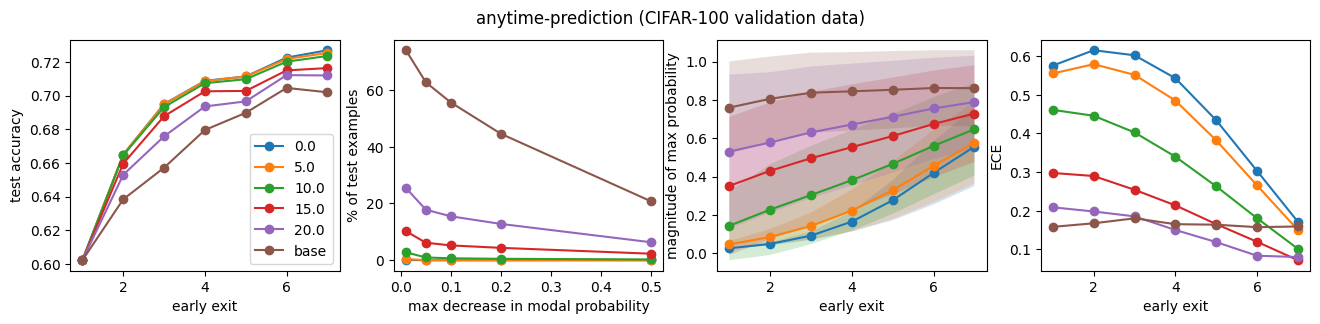

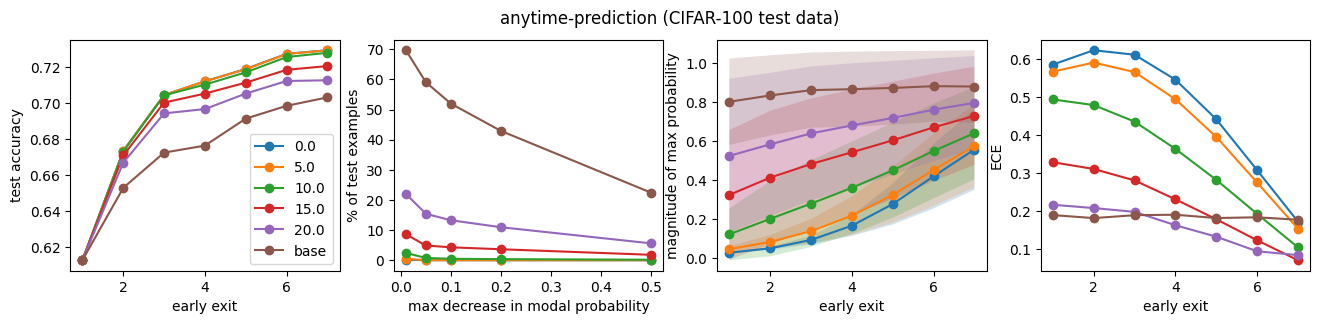

In [34]:
for _logits, _targets, _dict, _label in zip([logits_val, logits_test], [targets_val, targets_test], [C_dict_val, C_dict_test_w_log_reg_val], ['validation', 'test']):
    plot_adapt_thres(_logits, _targets, _dict, _label)
    

In [14]:
# C = 15 yields best ECE while not impacting accuracy and monotonicity too much
C_val = 15.

probs_poe_ovr_adapt_thres_log_reg_val, preds_poe_ovr_adapt_thres_log_reg_val, acc_poe_ovr_adapt_thres_log_reg_val = C_dict_test_w_log_reg_val[C_val]

## 2 Logistic Regression on train data

In [10]:
log_reg_train = fit_log_reg(logits_train, targets_train)

/home/metod/Desktop/PhD/year1/PoE/MSDNet-PyTorch/utils_notebook.py:802: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  top_K_logits, _ = torch.topk(torch.tensor(logits[l]), K, dim=1)


In [11]:
C_dict_train = grid_search_adapt_thres(logits_train, targets_train, log_reg_train)
C_dict_test_w_log_reg_train = grid_search_adapt_thres(logits_test, targets_test, log_reg_train)

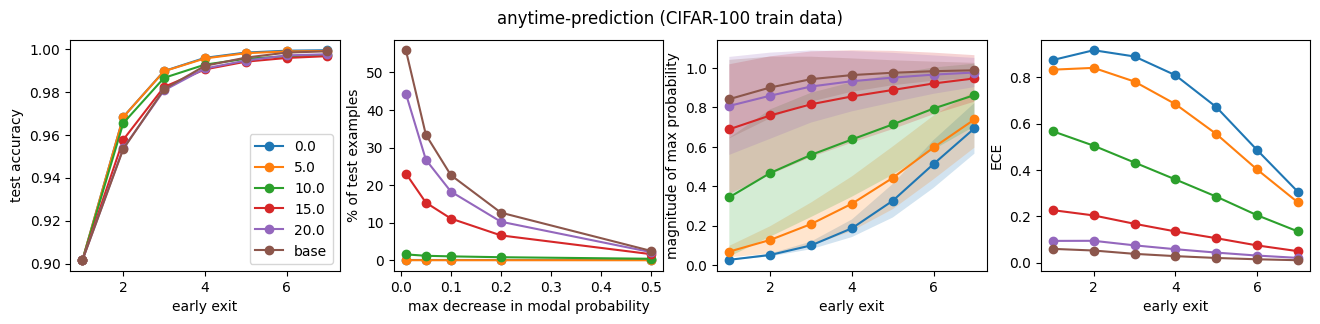

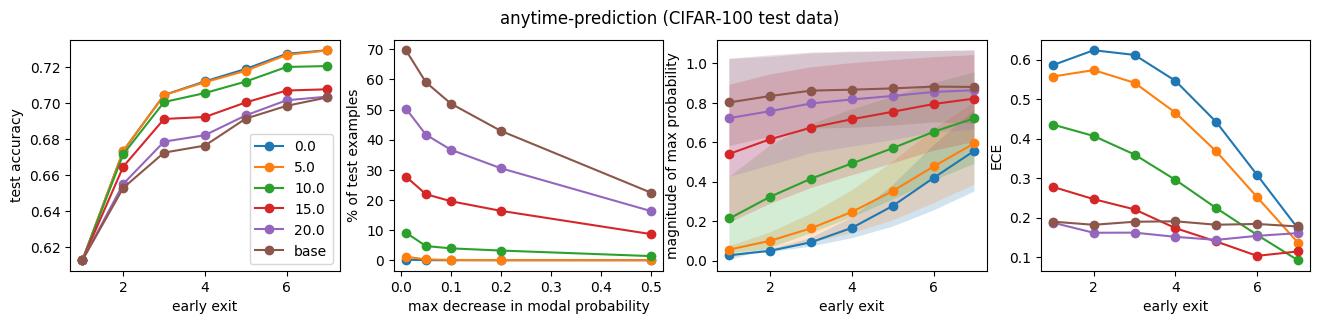

In [12]:
for _logits, _targets, _dict, _label in zip([logits_train, logits_test], [targets_train, targets_test], [C_dict_train, C_dict_test_w_log_reg_train], ['train', 'test']):
    plot_adapt_thres(_logits, _targets, _dict, _label)

In [13]:
# C = 15 yields best ECE while not impacting accuracy and monotonicity too much
C_train = 10.

probs_poe_ovr_adapt_thres_log_reg_train, preds_poe_ovr_adapt_thres_log_reg_train, acc_poe_ovr_adapt_thres_log_reg_train = C_dict_test_w_log_reg_train[C_train]

## 3 Simple binary adaptive thresholding

In [17]:
# CIFAR-10
# probs_poe_ovr_break_ties_generalized_adapt_thres = np.concatenate([np.nan_to_num(get_probs_ovr_poe_w_adaptive_threshold(logits=logits[:, n, :], weights=(np.arange(1, L + 1, 1, dtype=float) / L), thres_metric=5, thres_easy=6)) for n in range(N)], axis=1)

# CIFAR-100
probs_poe_ovr_adapt_thres = np.concatenate([np.nan_to_num(get_probs_ovr_poe_w_adaptive_threshold(logits=logits_test[:, n, :], 
                                                                                                 weights=(np.arange(1, L + 1, 1, dtype=float) / L))) for n in range(N)], 
                                                                                                 axis=1)

probs_poe_ovr_adapt_thres = torch.tensor(probs_poe_ovr_adapt_thres)
preds_poe_ovr_adapt_thres = {i: torch.argmax(probs_poe_ovr_adapt_thres, dim=2)[i, :] for i in range(L)}
acc_poe_ovr_adapt_thres = [(targets_test == preds_poe_ovr_adapt_thres[i]).sum() / len(targets_test) for i in range(L)]

## 4 Summary

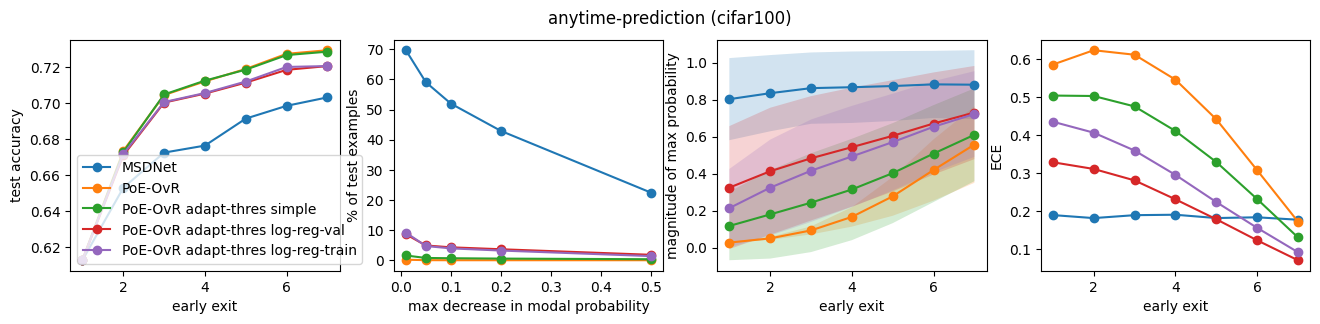

In [21]:
L, N = len(logits_test), len(targets_test)
early_exits = [i + 1 for i in range(L)]
fig, ax = plt.subplots(1, 4, figsize=(16, 3))


for _preds, _probs, _acc, label in [
                            (preds, probs, acc, 'MSDNet'),
                            (preds_poe_ovr, probs_poe_ovr, acc_poe_ovr, 'PoE-OvR'),
                            (preds_poe_ovr_adapt_thres, probs_poe_ovr_adapt_thres, acc_poe_ovr_adapt_thres, 'PoE-OvR adapt-thres simple'),
                            (preds_poe_ovr_adapt_thres_log_reg_val, probs_poe_ovr_adapt_thres_log_reg_val, acc_poe_ovr_adapt_thres_log_reg_val, 'PoE-OvR adapt-thres log-reg-val'),
                            (preds_poe_ovr_adapt_thres_log_reg_train, probs_poe_ovr_adapt_thres_log_reg_train, acc_poe_ovr_adapt_thres_log_reg_train, 'PoE-OvR adapt-thres log-reg-train'),
                            ]:

    ax[0].plot(early_exits, _acc, label=label, marker='o',)

    modal_probs = modal_probs_decreasing(_preds, _probs, layer=L, N=N)
    ax[1].plot(modal_probs.keys(), modal_probs.values(), marker='o', label=label)

    mean_magnitude, std_magnitude = _probs.max(2).values.mean(1), _probs.max(2).values.std(1)

    ax[2].plot(early_exits, mean_magnitude, marker='o', label=label)
    ax[2].fill_between(early_exits, mean_magnitude - std_magnitude, mean_magnitude + std_magnitude, alpha=0.2)

    ece = []
    for l in range(L):
        ece.append(ECE(bins=15).measure(_probs[l, :, :].numpy(), targets_test.numpy()))
    ax[3].plot(early_exits, ece, marker='o', label=label)


ax[0].legend()
# ax[0].set_title('anytime-prediction')
ax[0].set_ylabel('test accuracy')
ax[0].set_xlabel('early exit')

ax[1].set_xlabel('max decrease in modal probability')
ax[1].set_ylabel('% of test examples')

ax[2].set_xlabel('early exit')
ax[2].set_ylabel('magnitude of max probability')

ax[3].set_xlabel('early exit')
ax[3].set_ylabel('ECE')


plt.suptitle(f'anytime-prediction ({ARGS.data})')
plt.show()

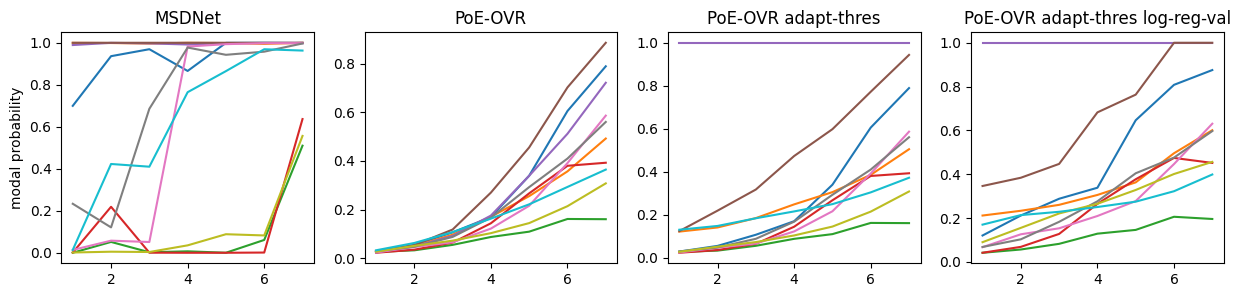

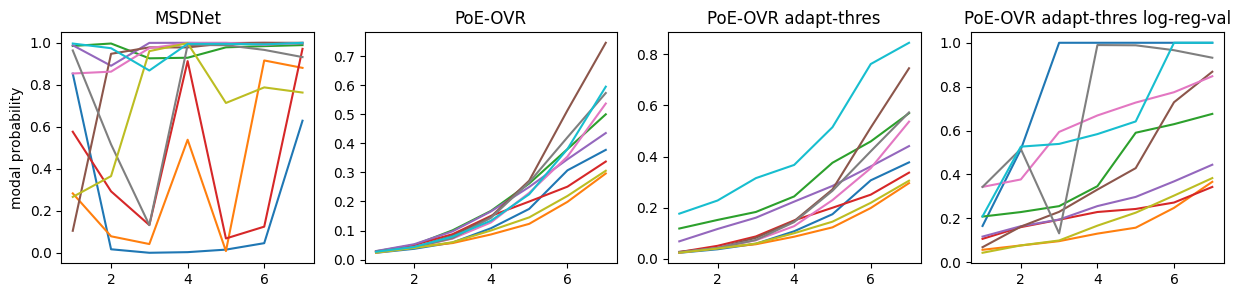

In [23]:
for _ in range(2):
    fig, ax = plt.subplots(1, 4, figsize=(15, 3))
    samples = random.sample(range(10000), 10)
    for i in samples:
        probs_i = probs_poe_ovr[:, i, preds_poe_ovr[L - 1][i]].cpu()
        probs_adapt_thres_i = probs_poe_ovr_adapt_thres[:, i, preds_poe_ovr_adapt_thres[L - 1][i]].cpu()
        probs_adapt_thres_log_reg_val_i = probs_poe_ovr_adapt_thres_log_reg_val[:, i, preds_poe_ovr_adapt_thres_log_reg_val[L - 1][i]].cpu()
        probs_i_baseline = probs[:, i, preds[L - 1][i]].cpu()
        ax[0].plot(list(range(1, len(probs_i_baseline) + 1)), probs_i_baseline, label=f'{i}');
        ax[1].plot(list(range(1, len(probs_i) + 1)), probs_i, label=f'{i}');
        ax[2].plot(list(range(1, len(probs_adapt_thres_i) + 1)), probs_adapt_thres_i, label=f'{i}');
        ax[3].plot(list(range(1, len(probs_adapt_thres_log_reg_val_i) + 1)), probs_adapt_thres_log_reg_val_i, label=f'{i}');
    # plt.savefig('/home/metod/Desktop/PhD/year1/PoE/MSDNet-PyTorch/modal_probs.pdf')
    # plt.legend()
    ax[0].set_title('MSDNet')
    ax[1].set_title('PoE-OVR')
    ax[2].set_title('PoE-OVR adapt-thres')
    ax[3].set_title('PoE-OVR adapt-thres log-reg-val')
    ax[0].set_ylabel('modal probability')
    plt.show()

In [24]:
quantiles = np.arange(0.1, 1., 0.05)

thres_arr_hetero = {q: [] for q in quantiles}
thres_arr_hetero_poe_ovr = {q: [] for q in quantiles}
thres_arr_hetero_poe_ovr_adapt_thres = {q: [] for q in quantiles}
thres_arr_hetero_poe_ovr_adapt_thres_log_reg_val = {q: [] for q in quantiles}
_probs = probs.max(dim=2).values
_probs_poe_ovr = probs_poe_ovr.max(dim=2).values
_probs_poe_ovr_adapt_thres = probs_poe_ovr_adapt_thres.max(dim=2).values
_probs_poe_ovr_adapt_thres_log_reg_val = probs_poe_ovr_adapt_thres_log_reg_val.max(dim=2).values
for l in range(L):
    for q in quantiles:
        thres_arr_hetero[q].append(np.quantile(_probs[l, :].flatten(), q))
        thres_arr_hetero_poe_ovr[q].append(np.quantile(_probs_poe_ovr[l, :].flatten(), q))
        thres_arr_hetero_poe_ovr_adapt_thres[q].append(np.quantile(_probs_poe_ovr_adapt_thres[l, :].flatten(), q))
        thres_arr_hetero_poe_ovr_adapt_thres_log_reg_val[q].append(np.quantile(_probs_poe_ovr_adapt_thres_log_reg_val[l, :].flatten(), q))

In [25]:
budget_dict_hetero = {name: [] for name in ['MSDNet', 'PoE-OVR', 'PoE-OVR adapt-thres', 'PoE-OVR adapt-thres log-reg-val']}
for name, _thres_arr, _probs in zip(['MSDNet', 'PoE-OVR', 'PoE-OVR adapt-thres', 'PoE-OVR adapt-thres log-reg-val'], 
                                    [thres_arr_hetero, thres_arr_hetero_poe_ovr, thres_arr_hetero_poe_ovr_adapt_thres, thres_arr_hetero_poe_ovr_adapt_thres_log_reg_val], 
                                    [probs, probs_poe_ovr, probs_poe_ovr_adapt_thres, probs_poe_ovr_adapt_thres_log_reg_val]):
    for thres_quantile in _thres_arr.keys():
        _preds_terminated = []
        for n in range(N):
            exited = False
            for l in range(L):
                if _probs[l, n, :].max() >= _thres_arr[thres_quantile][l]:
                    _preds_terminated.append((l+ 1, _probs[l, n, :].argmax()))
                    exited = True
                    break
            if not exited:
                _preds_terminated.append((L, _probs[L - 1, n, :].argmax()))
        budget_dict_hetero[name].append((float((torch.stack([x[1] for x in _preds_terminated]) == targets_test).sum() / N), 
                                         np.mean([x[0] for x in _preds_terminated]), 
                                         thres_quantile))

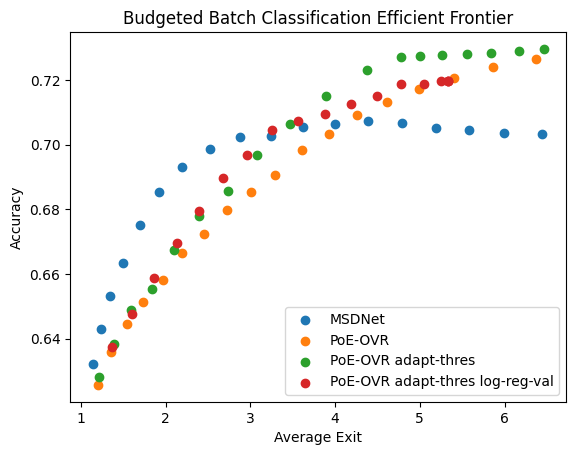

In [26]:
plt.scatter([x[1] for x in budget_dict_hetero['MSDNet']], [x[0] for x in budget_dict_hetero['MSDNet']], label='MSDNet', marker='o')
plt.scatter([x[1] for x in budget_dict_hetero['PoE-OVR']], [x[0] for x in budget_dict_hetero['PoE-OVR']], label='PoE-OVR', marker='o')
plt.scatter([x[1] for x in budget_dict_hetero['PoE-OVR adapt-thres']], [x[0] for x in budget_dict_hetero['PoE-OVR adapt-thres']], label='PoE-OVR adapt-thres', marker='o')
plt.scatter([x[1] for x in budget_dict_hetero['PoE-OVR adapt-thres log-reg-val']], [x[0] for x in budget_dict_hetero['PoE-OVR adapt-thres log-reg-val']], label='PoE-OVR adapt-thres log-reg-val', marker='o')
# plt.scatter([1], [1], label='oracle', marker='o', color='tab:red')
plt.xlabel('Average Exit')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Budgeted Batch Classification Efficient Frontier')
plt.show()